## CoastSat.slope


This code is an adaptation of the script by K. Vos, available at https://github.com/kvos/CoastSat.slope, 
where a detailed description of the method and implementation can be found.

Purpose:
The script calculates beach slopes along transects in 6 sites in Buenos Aires (Argentina) using shoreline data 
extracted by CoastSat (https://github.com/kvos/CoastSat) and tide data from the FES2022 model.

Overview:
1. Defines directories and site-specific parameters for shoreline and transect data.
2. Loads shoreline data and extracts intersections for each transect.
3. Applies quality control settings to filter shoreline points and outliers.
4. Retrieves tidal data from the FES2022 model to apply tide correction to cross-shore distances.
5. Computes beach slopes using the corrected shoreline positions and outputs the results as CSV files 
   for further analysis.
6. Stores tidal data over a specified date range for potential future corrections on satellite-derived beach widths.

Requirements:
- CoastSat: For extracting shoreline data.
- FES2022 model: For obtaining tide data and correcting shoreline positions.



In [1]:
# initial settings
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import pickle
import pandas as pd
import geopandas as gpd
# beach slope estmation module
from coastsat import SDS_slope, SDS_transects, SDS_tools

In [2]:
# Define directories and load transects
base_dir = os.getcwd()  # Set the base directory as the current working directory
dir_shorelines = os.path.join(base_dir, 'SDS', 'shorelines_local_image_classificatio_model')  # Directory for shoreline data
dir_transects = os.path.join(base_dir, 'SDS', 'transects', 'transects.geojson')  # Path to transect GeoJSON file
dir_tide = os.path.join(base_dir, 'Tide')  # Directory for tide data
dir_slope = os.path.join(base_dir, 'Slopes')  # Directory for slope data

# List of site names and corresponding transect keys
sitename = ['Punta Raza', 'Mar del Tuyu', 'Mar de Ajo', 'Nueva Atlantis', 'Pinamar', 'Mar de las Pampas']
transect_keys = ['PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP']

# Load transects from the GeoJSON file
loaded_transects = SDS_tools.transects_from_geojson(dir_transects)
transects = {key: value for key, value in zip(transect_keys, loaded_transects)}  # Create a dictionary of transects


6 transects have been loaded coordinates are in epsg:32721


In [3]:
#  Define parameters for computing intersections and removing outliers
settings_transects = {
    'along_dist': 25,         # Distance along the shore to use when calculating intersections
    'min_points': 3,          # Minimum number of shoreline points to calculate an intersection
    'max_std': 15,            # Maximum standard deviation for points around the transect
    'max_range': 30,          # Maximum range for points around the transect
    'min_chainage': -100,     # Maximum negative value along the transect (landward from transect origin)
    'multiple_inter': 'auto', # Mode for handling multiple intersections ('auto', 'nan', 'max')
    'auto_prc': 0.1,          # Threshold for using max intersection in case of multiple intersects
    'max_cross_change': 60
}

settings_outliers = {
    'max_cross_change': 60,          # Maximum change allowed between consecutive time steps
    'otsu_threshold': [-0.5, 0],     # Intensity threshold for shoreline contouring
    'plot_fig': True                 # Plot intermediate steps if True
}

# Define constants
days_in_year = 365.2425
seconds_in_day = 24 * 3600

# Define slope calculation settings
settings_slope = {
    'slope_min': 0.01,               # Minimum slope to test
    'slope_max': 0.2,                # Maximum slope to test
    'delta_slope': 0.005,            # Incremental slope value
    'date_range': [1999, 2020],      # Date range for analysis
    'n_days': 8,                     # Sampling period in days
    'n0': 50,                        # Nyquist criterion parameter for Lomb-Scargle transforms
    'freq_cutoff': 1./(seconds_in_day * 30),  # Cutoff frequency (1 month)
    'delta_f': 100 * 1e-10,          # Frequency delta for identifying tidal peak band
    'prc_conf': 0.01,                # Confidence band percentage in energy curve
    'plot_fig': True
}

# Set date range to UTC format
settings_slope['date_range'] = [pytz.utc.localize(datetime(settings_slope['date_range'][0], 1, 1)),
                                pytz.utc.localize(datetime(settings_slope['date_range'][1], 1, 1))]

# Calculate beach slopes within the defined slope range
beach_slopes = SDS_slope.range_slopes(settings_slope['slope_min'], settings_slope['slope_max'], settings_slope['delta_slope'])


*PR  - outliers removed: 39
MDT  - outliers removed: 20
MDA  - outliers removed: 16
NA  - outliers removed: 28
PI  - outliers removed: 68
MDP  - outliers removed: 51


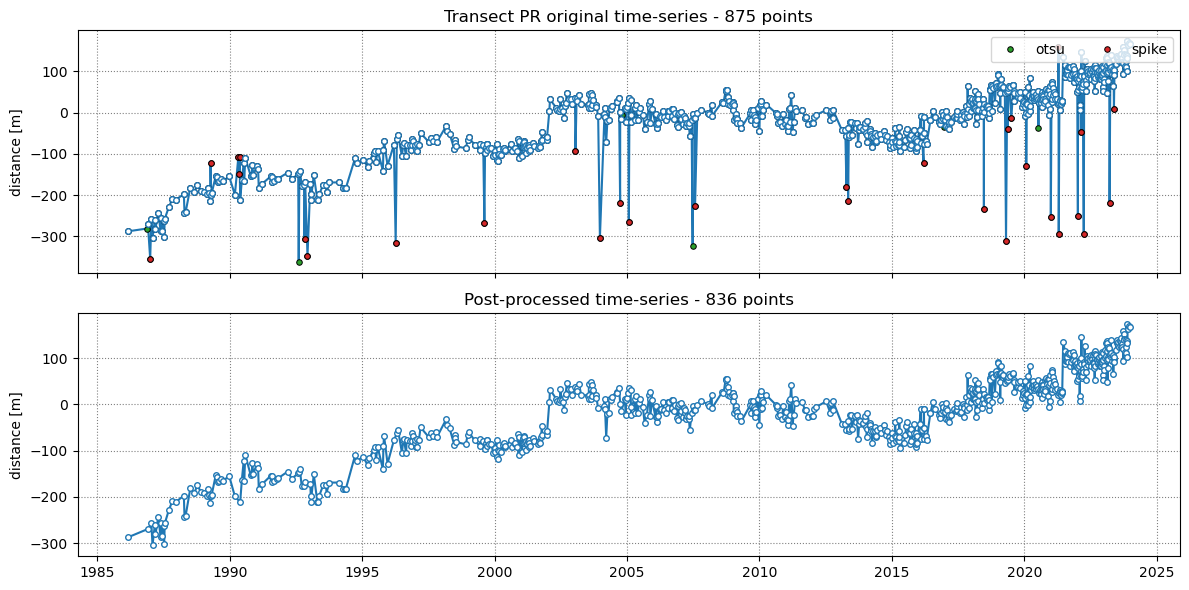

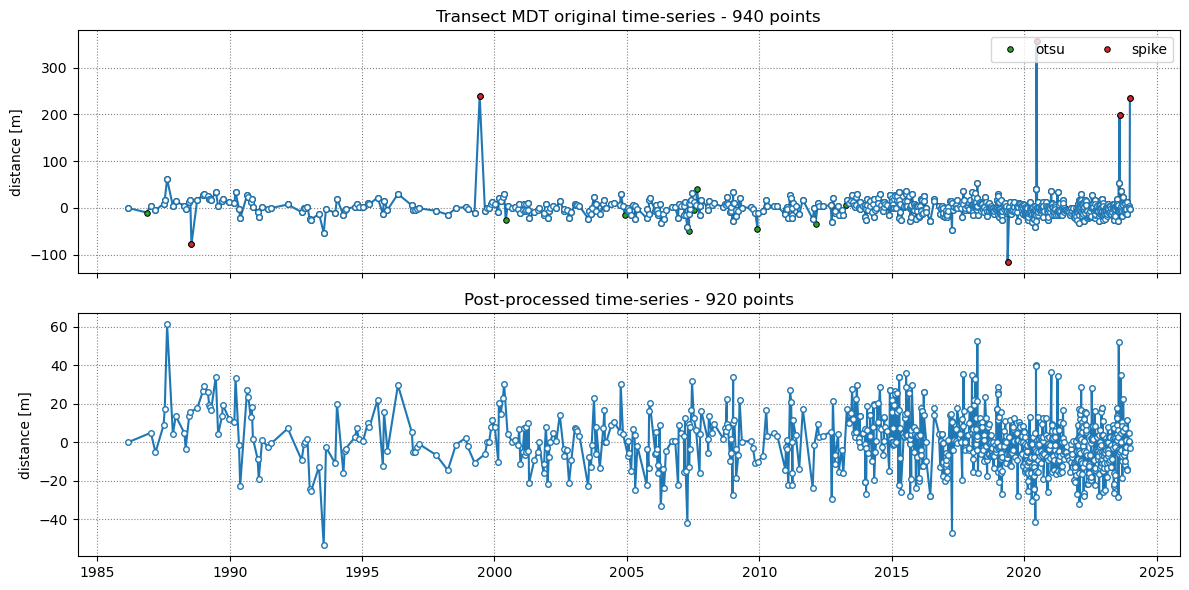

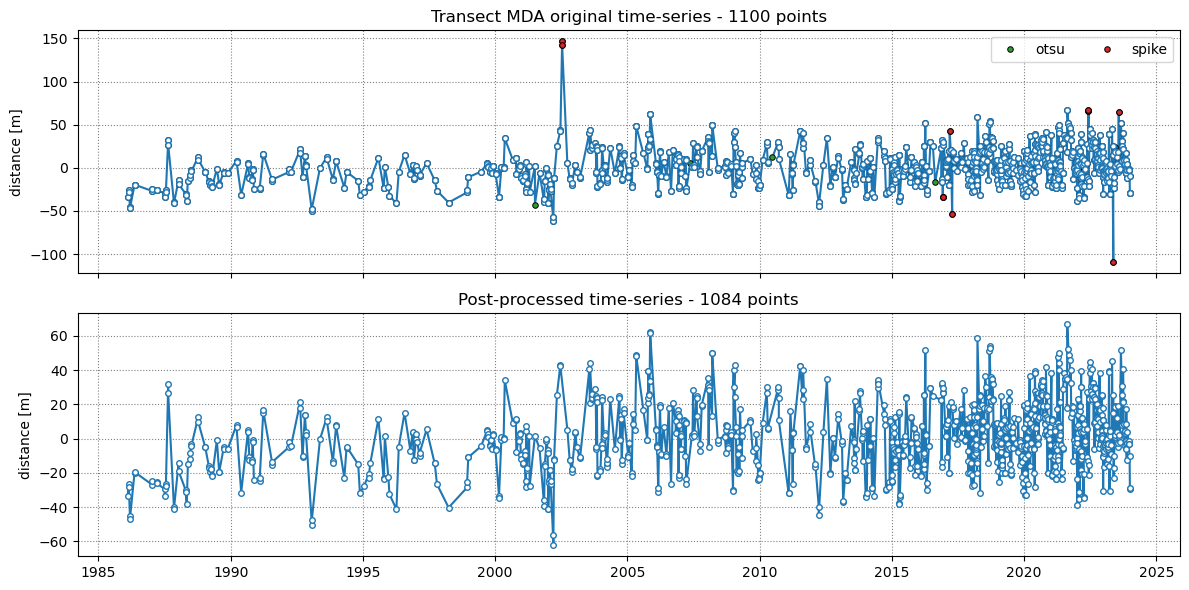

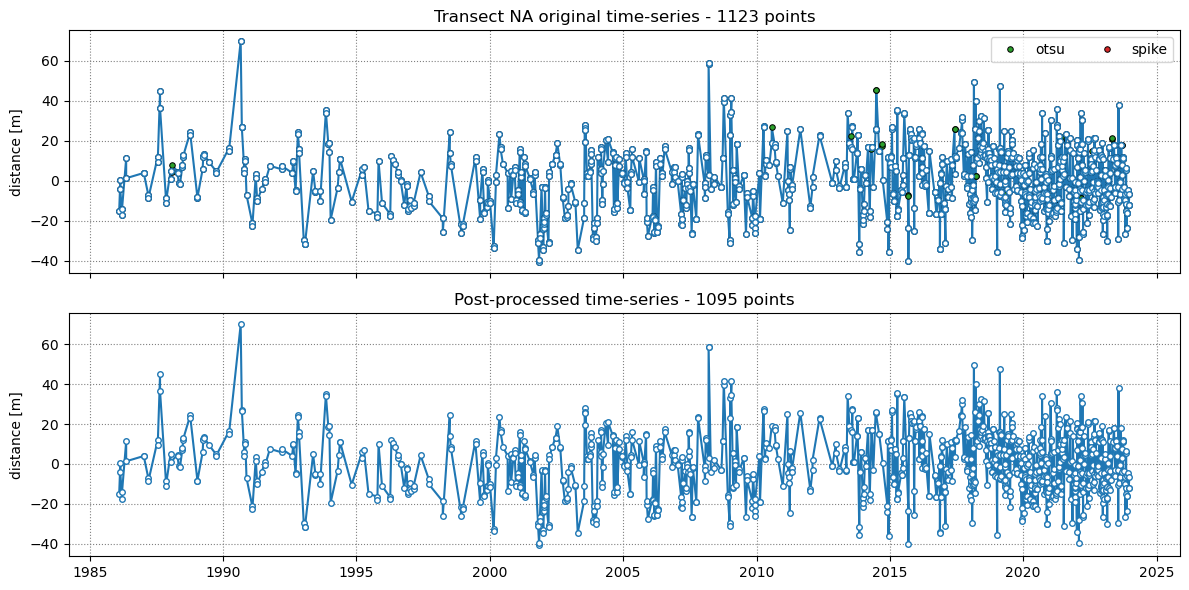

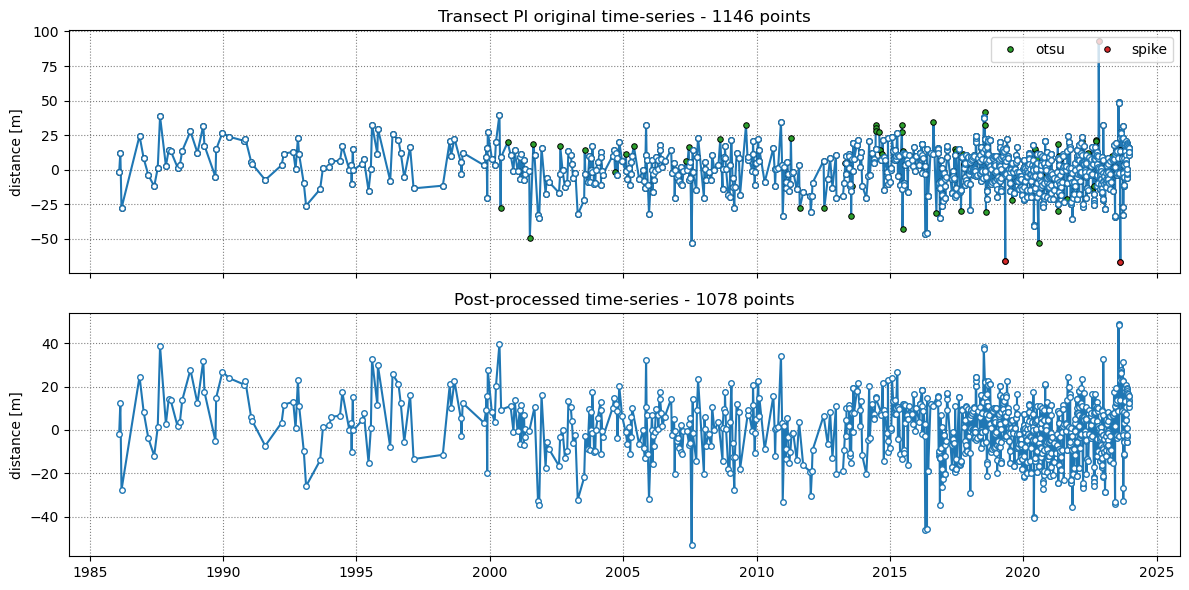

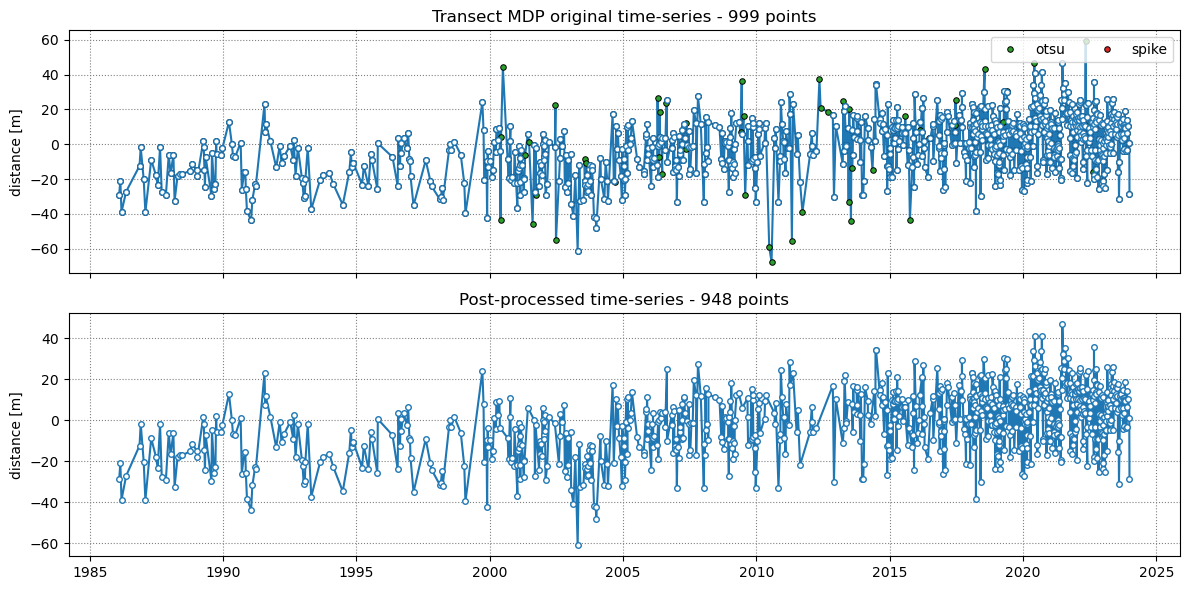

In [4]:
# Cell 3: Calculate intersections and remove outliers
cross_distance = {}  # Dictionary to store beach width (BW) data
dates_sat = {}  # Dictionary to store dates
output_all = {}  # Dictionary to store all outputs

# Process output files for each site
for i, key in enumerate(transect_keys):
    site = sitename[i]
    filepath = os.path.join(dir_shorelines, site)
    with open(os.path.join(filepath, site + '_output' + '.pkl'), 'rb') as f:
        output = pickle.load(f)
    output_all[key] = output  # Save output for current site

    # Retrieve transects for the current site using dictionary keys
    site_transects = loaded_transects[transect_keys[i]]
    transects_dict = {transect_keys[i]: site_transects}

    # Calculate intersections and remove outliers
    cross_distance1 = SDS_transects.compute_intersection_QC(output, transects_dict, settings_transects)
    cross_distance2 = SDS_transects.reject_outliers(cross_distance1, output, settings_outliers)

    # Convert dates in output to datetime format
    output['dates'] = pd.to_datetime(output['dates'], utc=True)

    # Identify date indices within the desired range
    idx_dates = [np.logical_and(_ > settings_slope['date_range'][0], _ < settings_slope['date_range'][1]) for _ in output['dates']]
    dates_sat1 = [output['dates'][_] for _ in np.where(idx_dates)[0]]

    # Select cross distance values within the date range
    cross_distance3 = cross_distance2[key][idx_dates]
    cross_distance3_dict = {key: cross_distance3}
    cross_distance.update(cross_distance3_dict)

    # Save corresponding dates
    dates_sat1_dict = {key: dates_sat1}
    dates_sat.update(dates_sat1_dict)

In [5]:
# Load FES2022 tidal data
import pyfes

filepath = r'/Users/carolinbillet/Documents/aviso-fes-main/data/fes2022b'  # Set path to local FES2022 data
config = os.path.join(filepath, 'fes2022.yaml')
handlers = pyfes.load_config(config)
ocean_tide = handlers['tide']  # Load ocean tide data
load_tide = handlers['radial']  # Load radial tide data


# Load the GeoJSON file containing tide nodes coordinates
gdf = gpd.read_file(os.path.join(dir_tide, 'tide nodes.geojson'))
# Assign names to each node using the keys from the 'transects' dictionary
gdf["name"] = transects.keys()
gdf = gdf.set_index('name')
# Create a dictionary of coordinates for each node
# For longitude, 360 is added to ensure values are in the correct range for processing
coords_dict = {name: [360 + geometry.x, geometry.y] for name, geometry in gdf.geometry.items()}
# Create a list of keys (node names) based on the dictionary of coordinates
cross_distance_keys = list(coords_dict.keys())

Beach slope at transect PR: 0.040
('PR', [0.035, 0.0425])
Beach slope at transect MDT: 0.045
('MDT', [0.045, 0.05])
Beach slope at transect MDA: 0.035
('MDA', [0.0325, 0.035])
Beach slope at transect NA: 0.040
('NA', [0.04, 0.04])
Beach slope at transect PI: 0.050
('PI', [0.045, 0.05])
Beach slope at transect MDP: 0.045
('MDP', [0.0425, 0.045])


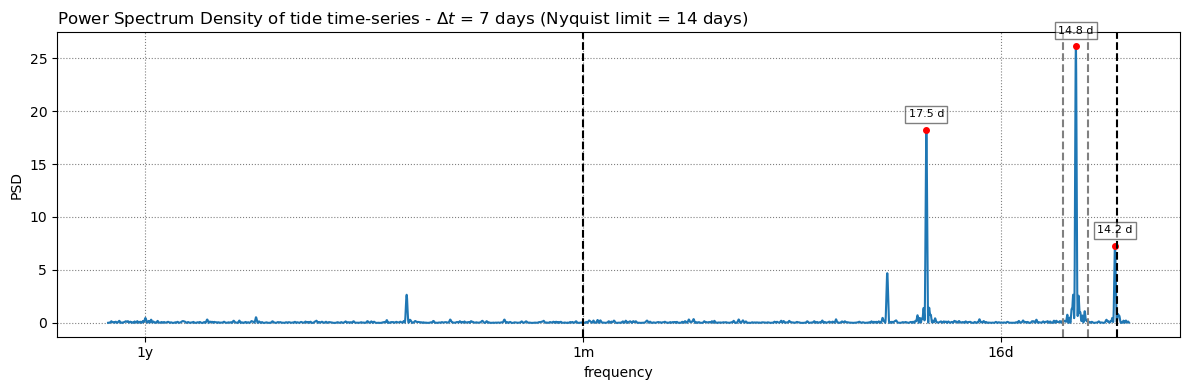

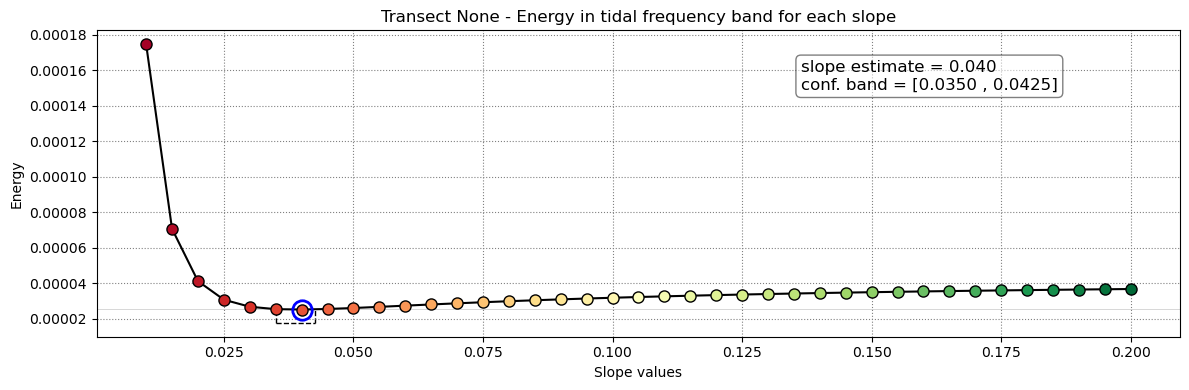

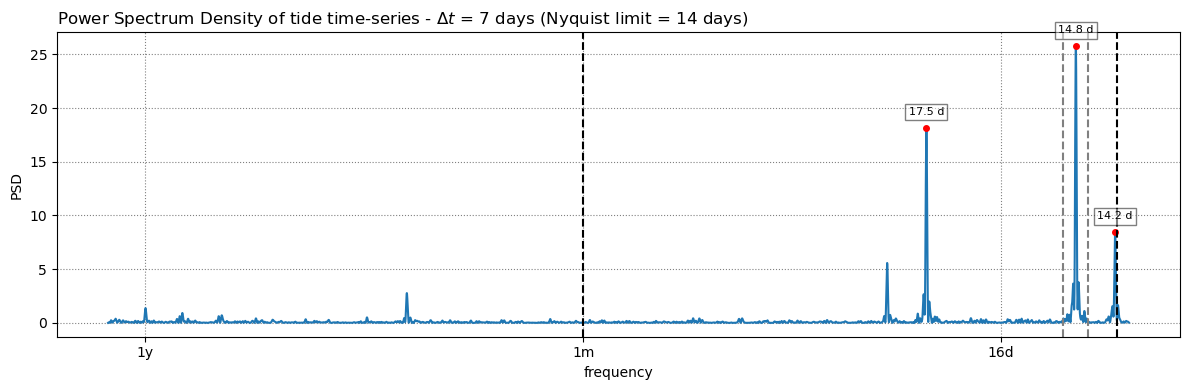

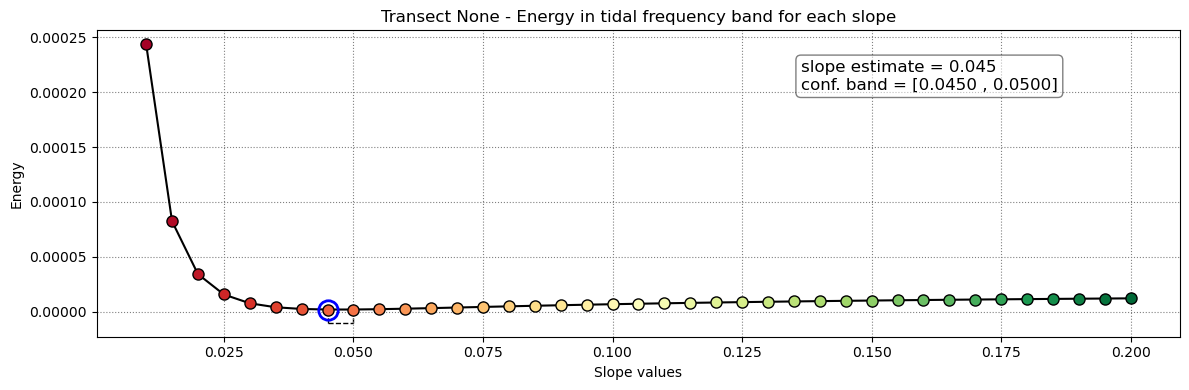

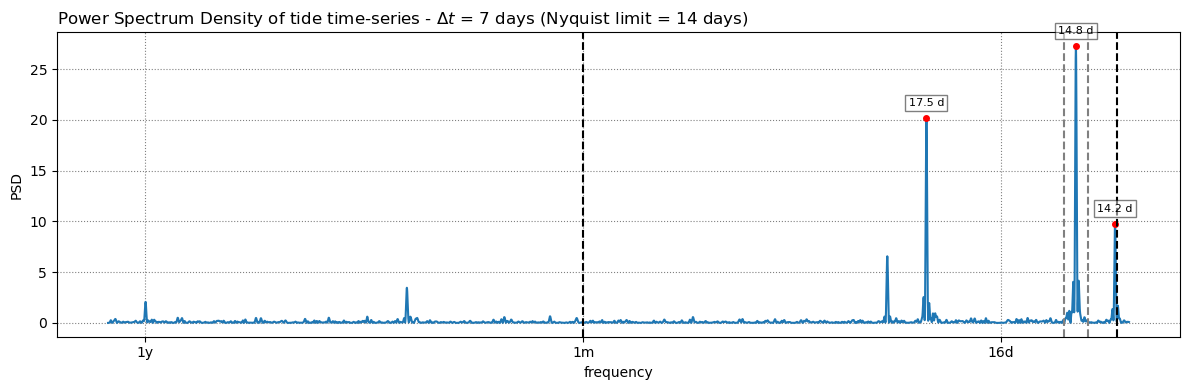

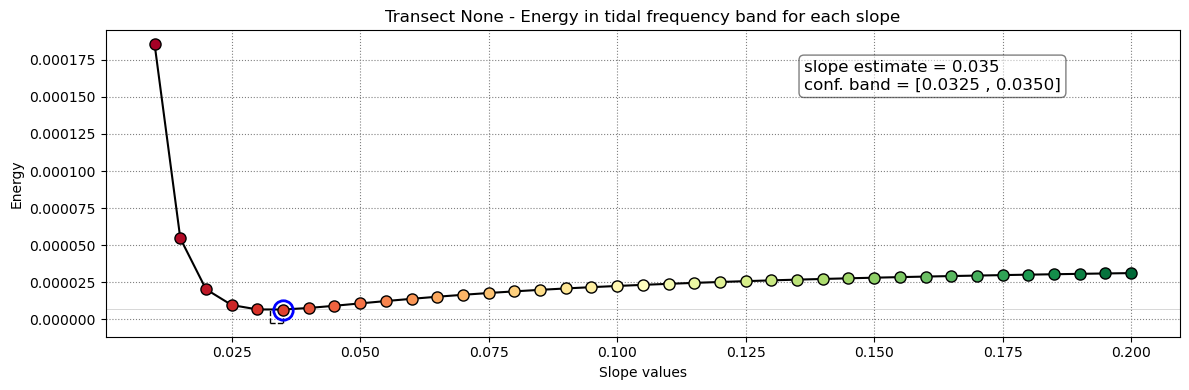

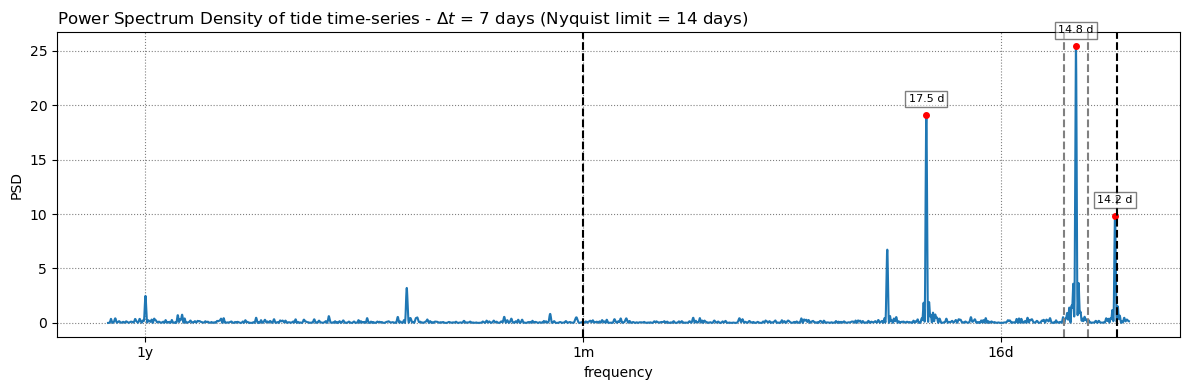

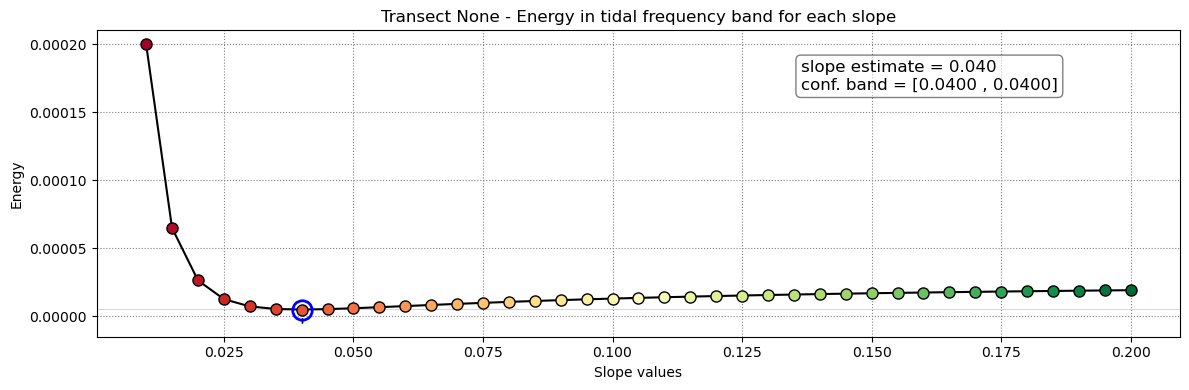

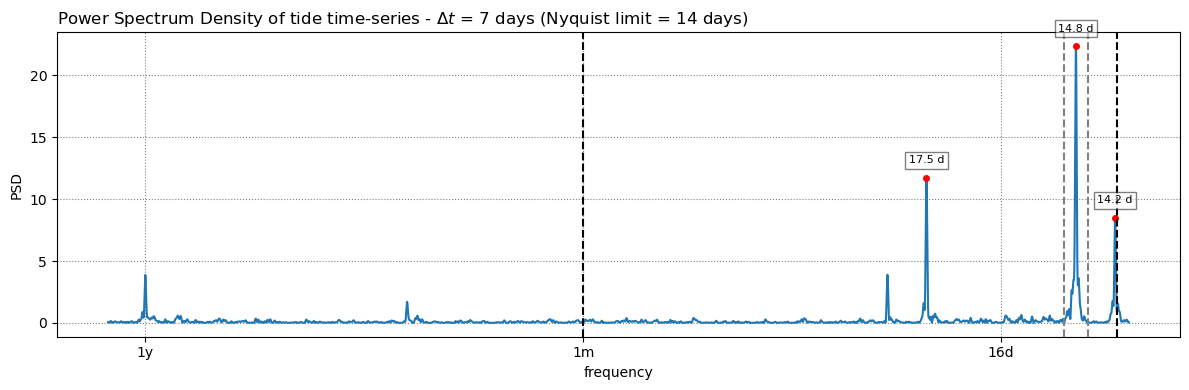

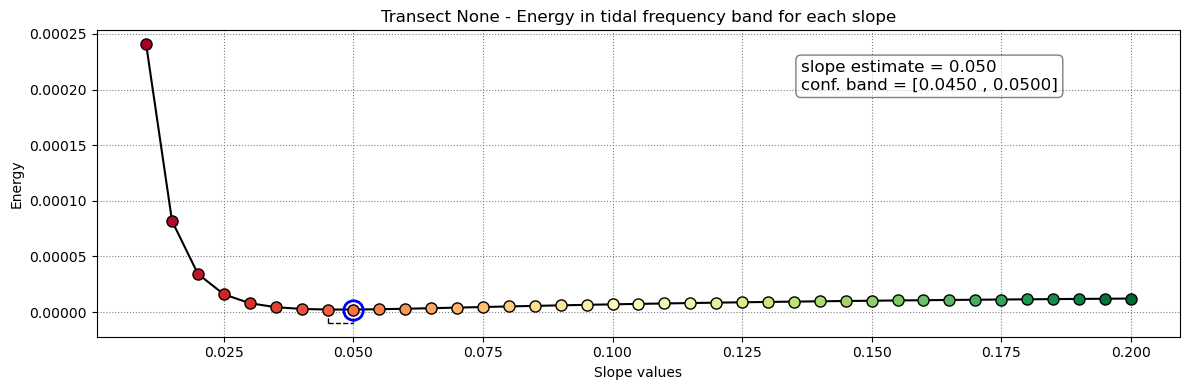

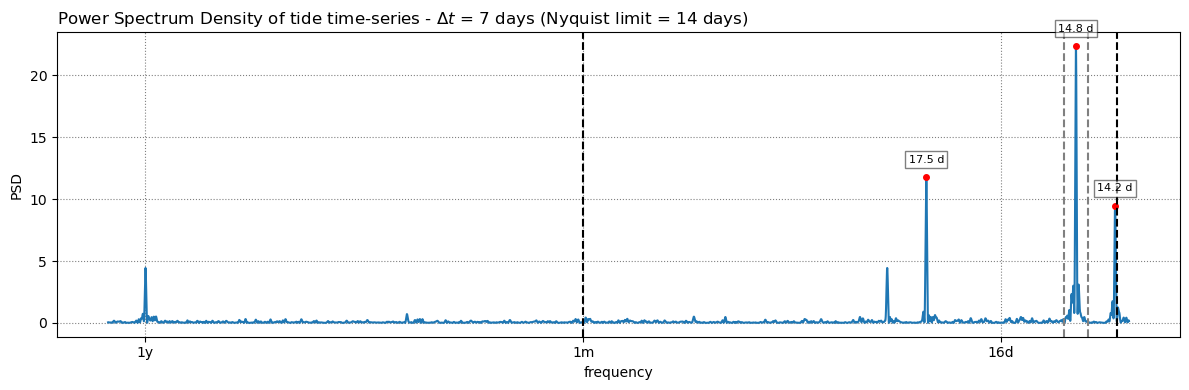

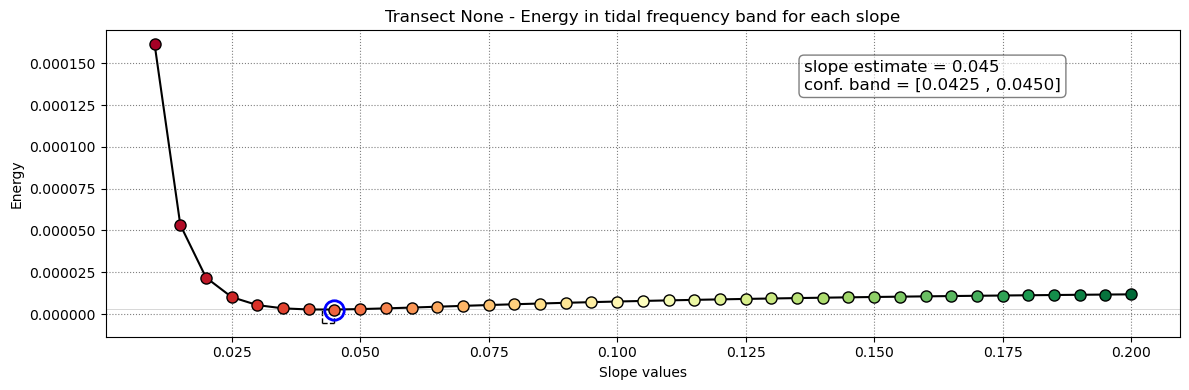

In [6]:
# Cell 5: Estimate beach slopes and confidence intervals
slope_est, cis = dict(), dict()  # Dictionaries for storing slope estimates and confidence intervals
slope_final = []
cis_fin = []

# Loop over keys and calculate tide_sat and final slopes
for key in cross_distance_keys:
    coords = coords_dict[key]  # Retrieve corresponding coordinates
    dates_sat1 = dates_sat[key]

    # Compute tide_sat for the current coordinates
    tide_sat = SDS_slope.compute_tide_dates(coords, dates_sat1, ocean_tide, load_tide)

    # Find tidal peak frequency
    settings_slope['n_days'] = 7
    settings_slope['freqs_max'] = SDS_slope.find_tide_peak(dates_sat1, tide_sat, settings_slope)
    idx_nan = np.isnan(cross_distance[key])

    # Filter out NaN values from dates and corresponding tide_sat and cross_distance values
    dates = [dates_sat1[_] for _ in np.where(~idx_nan)[0]]
    tide = tide_sat[~idx_nan]
    composite = cross_distance[key][~idx_nan]

    # Correct tide and calculate power spectrum
    tsall = SDS_slope.tide_correct(composite, tide, beach_slopes)
    title = 'Transect %s' % key

    # Estimate beach slope and confidence intervals
    slope_est[key], cis[key] = SDS_slope.integrate_power_spectrum(dates, tsall, settings_slope)
    print('Beach slope at transect %s: %.3f' % (key, slope_est[key]))
    print((key, cis[key]))

    # Save results
    slope_final.append(slope_est[key])
    cis_fin.append(cis[key])



In [7]:
#  Save slope estimates to CSV
slopes = pd.DataFrame(slope_final, columns=['slope'])
slopes['error'] = cis_fin  # Add confidence intervals as error
slopes.to_csv(os.path.join(dir_slope, 'slope_cs.csv'))  # Save to CSV file


#  Save tidal data for future correction of satellite-derived beach widths

In [8]:
#  Save tidal data for future correction of satellite-derived beach widths
timestep = 60 * 60  # Time step in seconds (1 hour)

# Define the date range and convert to datetime
date_range = [datetime(1985, 1, 1), datetime(2021, 12, 31)]

# Create an empty DataFrame with dates_ts as index
dates_ts, _ = SDS_slope.compute_tide(coords_dict[cross_distance_keys[0]], date_range, timestep, ocean_tide, load_tide)
df_tides = pd.DataFrame(index=dates_ts)
df_tides['dates']=df_tides.index

# Compute and save tide data
for key in cross_distance_keys:
    coords = coords_dict[key]
    dates_ts, tides_ts = SDS_slope.compute_tide(coords, date_range, timestep, ocean_tide, load_tide)
    df_tides[key] = tides_ts

df_tides.to_csv(os.path.join(dir_tide,'tide_fes2022.csv'))
